<a href="https://colab.research.google.com/github/Haebuk/dataminingTP/blob/main/TP_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PATH = '/content/drive/MyDrive/input/dataminingTP/'
train_df = pd.read_csv(PATH + 'train.csv')
test_df = pd.read_csv(PATH + 'test.csv')

In [3]:
print(train_df.shape, test_df.shape)

(1216553, 13) (5463, 12)


In [4]:
train_df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


In [5]:
test_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1145756,10453,서울특별시,목동,938,청학,목동 938 청학,35.55,2002,201711,11~20,2
1,1198704,989,부산광역시,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.72,1977,201708,21~31,2
2,1222384,8597,부산광역시,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.54,1989,201710,11~20,2


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5   apt                     1216553 non-null  object 
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 120.7+ M

In [7]:
train_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [62]:
train_df.loc[(train_df['transaction_real_price']==820000)]

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
23603,23603,11320,서울특별시,한남동,810,한남더힐,한남동 810 한남더힐,244.749,2011,201612,21~31,3,820000


In [63]:
train_df.loc[(train_df['transaction_real_price']==100)]

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
722888,722888,6225,부산광역시,범전동,263-5,서면,범전동 263-5 서면,138.25,1974,201606,21~30,-1,100


In [8]:
seoul_df = train_df[train_df['city'] == '서울특별시']
busan_df = train_df[train_df['city'] == '부산광역시']



In [9]:
print(len(seoul_df), len(busan_df), len(seoul_df) + len(busan_df))

742285 474268 1216553


In [10]:
train_df['dong'].nunique()

473

In [11]:
train_df['apt'].nunique()

10440

In [12]:
# 서울
seoul_df.loc[seoul_df['city'] == '서울특별시', 'dong'].value_counts()

상계동    29346
중계동    17079
신정동    16902
창동     15474
구로동    14372
       ...  
주성동        2
누상동        2
옥인동        1
구수동        1
효제동        1
Name: dong, Length: 330, dtype: int64

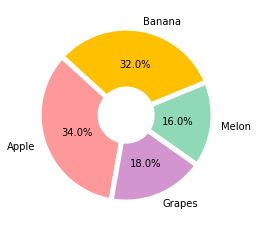

In [13]:

ratio = [34, 32, 16, 18]
labels = ['Apple', 'Banana', 'Melon', 'Grapes']
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
plt.show()

In [14]:
test_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,2000.431082,201710.228446,8.266886
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475
min,1.092791e+06,12.000000,10.321500,1961.000000,201701.000000,-1.000000
25%,1.134296e+06,3278.000000,59.760000,1995.000000,201709.000000,4.000000
50%,1.167937e+06,6091.000000,81.720000,2002.000000,201712.000000,7.000000
75%,1.202560e+06,9416.500000,84.970000,2007.000000,201712.000000,11.000000
max,1.234930e+06,12652.000000,273.860000,2017.000000,201712.000000,55.000000


In [15]:
train_df

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.8200,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.1700,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.7400,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.3900,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.4300,2004,200801,21~31,3,120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,1234823,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,59.8245,2012,201711,11~20,3,22000
1216549,1234824,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,7,30750
1216550,1234825,9578,부산광역시,정관읍 용수리,1387,정관 동일스위트1차,정관읍 용수리 1387 정관 동일스위트1차,84.9923,2012,201711,21~30,9,29500
1216551,1234826,9586,부산광역시,정관읍 용수리,1364,정관신도시롯데캐슬,정관읍 용수리 1364 정관신도시롯데캐슬,101.7400,2008,201711,21~30,7,26700


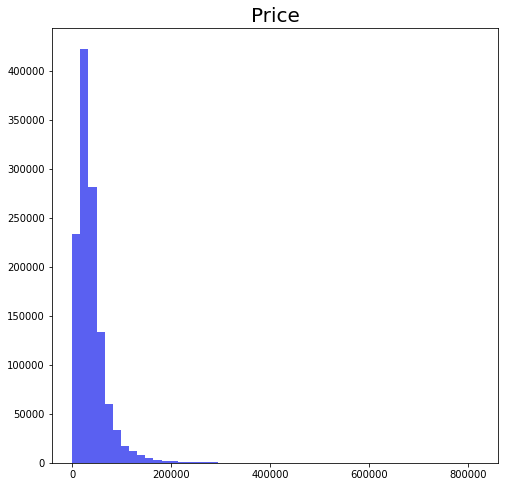

In [16]:
plt.figure(figsize=(8, 8))
plt.hist(train_df['transaction_real_price'], bins=50, color='#5a60f1')
plt.title('Price', size=20)
plt.show()

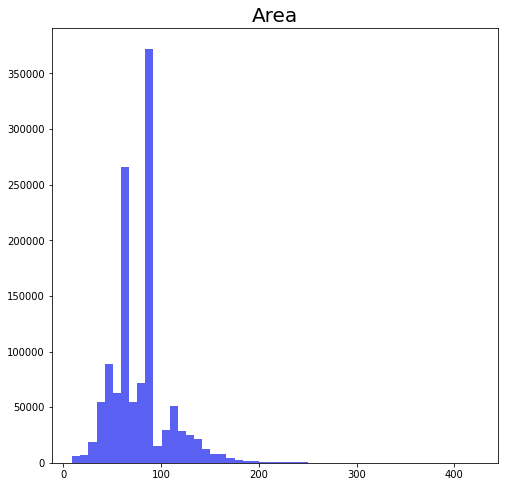

In [17]:
plt.figure(figsize=(8, 8))
plt.hist(train_df['exclusive_use_area'], bins=50, color='#5a60f1')
plt.title('Area', size=20)
plt.show()

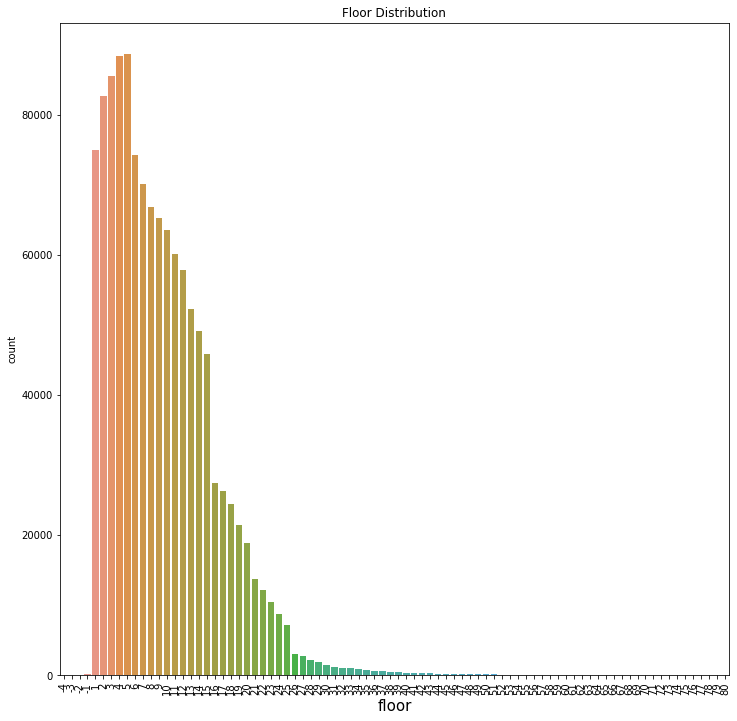

In [30]:
plt.figure(figsize=(12,12))
sns.countplot(x='floor', data=train_df)
plt.xticks(rotation=90)
plt.title('Floor Distribution')
plt.xlabel('floor',fontsize=15)
plt.show()

In [32]:
len(under)

168

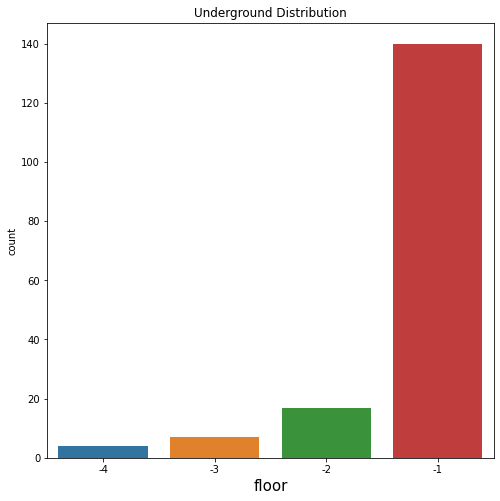

In [31]:
under = train_df[train_df['floor']<0]
plt.figure(figsize=(8,8))
sns.countplot(x='floor', data=under)
plt.title('Underground Distribution')
plt.xlabel('floor',fontsize=15)
plt.show()

Text(0.5, 1.0, 'Floor + Price Heatmap')

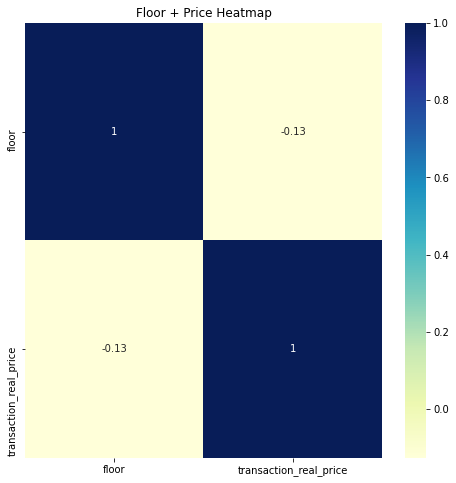

In [59]:
under[['floor', 'transaction_real_price']].corr()
plt.figure(figsize=(8,8))
sns.heatmap(under[['floor', 'transaction_real_price']].corr(),cmap='YlGnBu', annot=True)
plt.title('Floor + Price Heatmap')